# Time processing for every ONNX nodes in a graph

The following notebook show how long the runtime spends in each node of an ONNX graph.

In [1]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

In [2]:
%load_ext mlprodict

## LogisticRegression

In [3]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
iris = load_iris()
X, y = iris.data, iris.target
X_train, X_test, y_train, y_test = train_test_split(X, y)
clr = LogisticRegression(solver='liblinear')
clr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [4]:
import numpy
from mlprodict.onnxrt import to_onnx
onx = to_onnx(clr, X_test.astype(numpy.float32))
# add -l 1 if nothing shows up
%onnxview onx

In [5]:
from mlprodict.onnxrt import OnnxInference
import pandas
oinf = OnnxInference(onx)
res = oinf.run({'X': X_test}, node_time=True)
pandas.DataFrame(list(res[1]))

,i,name,op_type,time
0,0,LinearClassifier,LinearClassifier,0.033075
1,1,Normalizer,Normalizer,0.000069
2,2,Cast,Cast,0.000012
3,3,ZipMap,ZipMap,0.000010


In [6]:
oinf.run({'X': X_test})['output_probability'][:5]

{0: array([8.07364144e-01, 9.65650957e-04, 7.94815706e-03, 7.44953698e-04,
        8.24026492e-01]),
 1: array([0.1925058 , 0.47254553, 0.27030508, 0.24039944, 0.17593254]),
 2: array([1.30060489e-04, 5.26488815e-01, 7.21746759e-01, 7.58855602e-01,
        4.09691603e-05])}

## Measure time spent in each node


With parameter ``node_time=True``, method *run* returns the output and time measurement.

In [7]:
exe = oinf.run({'X': X_test}, node_time=True)
exe[1]

[{'i': 0,
  'name': 'LinearClassifier',
  'op_type': 'LinearClassifier',
  'time': 0.00020879999999934284},
 {'i': 1,
  'name': 'Normalizer',
  'op_type': 'Normalizer',
  'time': 5.510000000086279e-05},
 {'i': 2, 'name': 'Cast', 'op_type': 'Cast', 'time': 1.81000000001319e-05},
 {'i': 3,
  'name': 'ZipMap',
  'op_type': 'ZipMap',
  'time': 1.270000000097582e-05}]

In [8]:
import pandas
pandas.DataFrame(exe[1])

,i,name,op_type,time
0,0,LinearClassifier,LinearClassifier,0.000209
1,1,Normalizer,Normalizer,0.000055
2,2,Cast,Cast,0.000018
3,3,ZipMap,ZipMap,0.000013


## Logistic regression: python runtime vs onnxruntime

Function [enumerate_validated_operator_opsets](http://www.xavierdupre.fr/app/mlprodict/helpsphinx/mlprodict/onnxrt/validate/validate.html?highlight=enumerate_validated_operator_opsets#mlprodict.onnxrt.validate.validate.enumerate_validated_operator_opsets) implements automated tests for every model with artificial data. Option ``node_time`` automatically returns the time spent in each node and does it multiple time.

In [9]:
from mlprodict.onnxrt.validate import enumerate_validated_operator_opsets
res = list(enumerate_validated_operator_opsets(
            verbose=0, models={"LogisticRegression"}, opset_min=11,
            runtime='python', debug=False, node_time=True,
            filter_exp=lambda m, p: p == "b-cl"))

In [10]:
import pandas
df = pandas.DataFrame(res[0]['bench-batch'])
df['step'] = df.apply(lambda row: '{}-{}'.format(row['i'], row["name"]), axis=1)
df

,i,name,op_type,time,N,max_time,min_time,repeat,number,step
0,0,LinearClassifier,LinearClassifier,0.000027,1,0.000041,0.000016,20,30,0-LinearClassifier
1,1,Normalizer,Normalizer,0.000025,1,0.000035,0.000014,20,30,1-Normalizer
2,2,Cast,Cast,0.000008,1,0.000027,0.000004,20,30,2-Cast
3,3,ZipMap,ZipMap,0.000007,1,0.000011,0.000004,20,30,3-ZipMap
4,0,LinearClassifier,LinearClassifier,0.000037,10,0.000073,0.000024,20,20,0-LinearClassifier
5,1,Normalizer,Normalizer,0.000030,10,0.000042,0.000020,20,20,1-Normalizer
6,2,Cast,Cast,0.000009,10,0.000013,0.000006,20,20,2-Cast
7,3,ZipMap,ZipMap,0.000007,10,0.000010,0.000005,20,20,3-ZipMap
8,0,LinearClassifier,LinearClassifier,0.000037,100,0.000040,0.000032,5,8,0-LinearClassifier
9,1,Normalizer,Normalizer,0.000030,100,0.000032,0.000024,5,8,1-Normalizer


Following tables shows the time spent in each node, it is relative to the total time. For one observation, the runtime spends 10% of the time in ZipMap, it is only 1% or 2% with 10 observations. These proportions change due to the computing cost of each node.

In [11]:
piv = df.pivot('step', 'N', 'time')
total = piv.sum(axis=0)
piv / total

N,1,10,100,1000,10000,100000
step,,,,,,
0-LinearClassifier,0.406476,0.452828,0.450596,0.494004,0.560102,0.532585
1-Normalizer,0.371644,0.361076,0.363285,0.403272,0.405889,0.452958
2-Cast,0.122960,0.103683,0.102057,0.057268,0.022741,0.013022
3-ZipMap,0.098920,0.082413,0.084061,0.045457,0.011268,0.001436


The python implementation of *ZipMap* does not change the data but wraps in into a frozen class [ArrayZipMapDitionary](https://github.com/sdpython/mlprodict/blob/master/mlprodict/onnxrt/ops_cpu/op_zipmap.py#L90) which mocks a list of dictionaries *pandas* can ingest to create a DataFrame. The cost is a fixed cost and does not depend on the number of processed rows.

In [12]:
from pyquickhelper.pycode.profiling import profile
bigX = numpy.random.randn(100000, X_test.shape[1]).astype(numpy.float32)
df = profile(lambda: oinf.run({'X': bigX}), as_df=True)[1]
df['file'] = df['file'].apply(lambda s: s.split("GitHub")[-1])
df

,namefct,file,ncalls1,ncalls2,tin,cum_tin,tall,cum_tall
0,onnx_inference.py:314-run,\mlprodict\mlprodict\onnxrt\onnx_inference.py:314,2,2,3.200000e-05,3.880000e-05,3.068780e-02,4.603510e-02
1,372-_run_sequence_runtime,\mlprodict\mlprodict\onnxrt\onnx_inference.py:372,7,7,8.590000e-05,1.111000e-04,3.065580e-02,4.599630e-02
2,onnx_inference_node.py:112-run,\mlprodict\mlprodict\onnxrt\onnx_inference_nod...,24,24,8.200000e-05,1.402000e-04,3.056740e-02,4.588020e-02
3,_op.py:190-run,\mlprodict\mlprodict\onnxrt\ops_cpu\_op.py:190,4,4,5.797700e-03,5.803200e-03,3.020190e-02,4.530560e-02
4,_op.py:303-run,\mlprodict\mlprodict\onnxrt\ops_cpu\_op.py:303,2,2,8.200000e-06,1.380000e-05,2.092420e-02,3.138910e-02
5,<ipython-input-12-d4f3af6cfacf>:3-<lambda>,<ipython-input-12-d4f3af6cfacf>:3,2,2,1.090000e-05,1.090000e-05,3.069870e-02,3.069870e-02
6,op_linear_classifier.py:38-_run,\mlprodict\mlprodict\onnxrt\ops_cpu\op_linear_...,3,3,5.799200e-03,1.158610e-02,1.512650e-02,2.558320e-02
7,_op.py:270-run,\mlprodict\mlprodict\onnxrt\ops_cpu\_op.py:270,2,2,7.300000e-06,1.170000e-05,9.293200e-03,1.394200e-02
8,op_normalizer.py:61-_run,\mlprodict\mlprodict\onnxrt\ops_cpu\op_normali...,3,3,2.977800e-03,2.983100e-03,9.277700e-03,1.391920e-02
9,0-<built-in method numpy.core._multiarray_umat...,~:0,3,3,2.416100e-03,4.828200e-03,6.885100e-03,1.153370e-02


In [13]:
%matplotlib inline

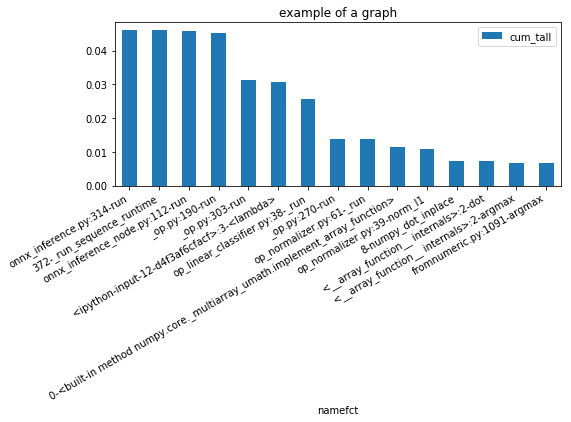

In [14]:
ax = df[['namefct', 'cum_tall']].head(n=15).set_index('namefct').plot(kind='bar', figsize=(8, 3), rot=30)
ax.set_title("example of a graph")
for la in ax.get_xticklabels():
    la.set_horizontalalignment('right');

The class *ArrayZipMapDictionary* is fast to build but has an overhead after that because it builds data when needed.

In [15]:
res = oinf.run({'X': bigX})
prob = res['output_probability']
type(prob)

mlprodict.onnxrt.ops_cpu.op_zipmap.ArrayZipMapDictionary

In [16]:
%timeit pandas.DataFrame(prob)

883 ms ± 70.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [17]:
list_of_dict = [v.asdict() for v in prob]
%timeit pandas.DataFrame(list_of_dict)

135 ms ± 5.54 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


But if you just need to do the following:

In [18]:
%timeit pandas.DataFrame(prob).values

829 ms ± 18.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Then, you can just do that:

In [19]:
print(prob.columns)
%timeit prob.values

[0, 1, 2]
196 ns ± 24 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


And then:


In [20]:
%timeit pandas.DataFrame(prob.values, columns=prob.columns)

222 µs ± 18.3 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


We can then compare to what *onnxruntime* would do when the runtime is called indenpently for each node. We use the runtime named [onnxruntime2](http://www.xavierdupre.fr/app/mlprodict/helpsphinx/onnx_runtime.html?highlight=onnxruntime2#onnxruntime2-independent-onnxruntime-for-every-node). Class *OnnxInference* splits the ONNX graph into multiple ONNX graphs, one for each node, and then calls *onnxruntime* for each of them indenpently. *Python* handles the graph logic.

In [21]:
res = list(enumerate_validated_operator_opsets(
            verbose=0, models={"LogisticRegression"}, opset_min=11,
            runtime='onnxruntime2', debug=False, node_time=True))
df = pandas.DataFrame(res[0]['bench-batch'])
df['step'] = df.apply(lambda row: '{}-{}'.format(row['i'], row["name"]), axis=1)
piv = df.pivot('step', 'N', 'time')
total = piv.sum(axis=0)
piv / total

N,1,10,100,1000,10000,100000
step,,,,,,
0-LinearClassifier,0.292338,0.284601,0.219738,0.148262,0.082890,0.116933
1-Normalizer,0.245823,0.230425,0.155208,0.068166,0.033344,0.032000
2-Cast,0.230882,0.215435,0.134094,0.031079,0.006377,0.006613
3-ZipMap,0.230958,0.269539,0.490961,0.752494,0.877389,0.844455


*onnxruntime* creates a new container each time a ZipMap is executed. That's whay it takes that much time and the ratio increases when the number of observations increases.

## GaussianProcessRegressor

This operator is slow for small batches compare to *scikit-learn* but closes the gap as the batch size increases. Let's see where the time goes.

In [22]:
res = list(enumerate_validated_operator_opsets(
            verbose=0, models={"GaussianProcessRegressor"}, opset_min=11,
            runtime='python', debug=False, node_time=True,
            filter_exp=lambda m, p: p == "b-reg"))

In [23]:
df = pandas.DataFrame(res[0]['bench-batch'])
df['step'] = df.apply(lambda row: '{0:02d}-{1}'.format(row['i'], row["name"]), axis=1)
df.head()

,i,name,op_type,time,N,max_time,min_time,repeat,number,step
0,0,Sc_Scan,Scan,0.005875,1,0.007438,0.004623,20,30,00-Sc_Scan
1,1,kgpd_Transpose,Transpose,0.000016,1,0.000020,0.000014,20,30,01-kgpd_Transpose
2,2,kgpd_Sqrt,Sqrt,0.000014,1,0.000016,0.000012,20,30,02-kgpd_Sqrt
3,3,kgpd_Div,Div,0.000014,1,0.000015,0.000011,20,30,03-kgpd_Div
4,4,kgpd_Mul,Mul,0.000010,1,0.000012,0.000008,20,30,04-kgpd_Mul


In [24]:
pivpy = df.pivot('step', 'N', 'time')
total = pivpy.sum(axis=0)
pivpy / total

N,1,10,100,1000,10000,100000
step,,,,,,
00-Sc_Scan,0.972494,0.962182,0.901074,0.637503,0.444311,0.617154
01-kgpd_Transpose,0.002720,0.002641,0.002317,0.001169,0.000340,0.000028
02-kgpd_Sqrt,0.002322,0.002553,0.002698,0.003304,0.005573,0.004761
03-kgpd_Div,0.002268,0.002674,0.002817,0.003374,0.006338,0.005241
04-kgpd_Mul,0.001692,0.002066,0.002182,0.002403,0.005693,0.005075
05-kgpd_Sin,0.002051,0.004945,0.024574,0.103039,0.147654,0.104190
06-kgpd_Div1,0.001590,0.001919,0.002350,0.003894,0.005647,0.004354
07-kgpd_Pow,0.002408,0.006544,0.036687,0.172732,0.287710,0.200715
08-kgpd_Mul1,0.001573,0.001975,0.002569,0.004804,0.005201,0.003702


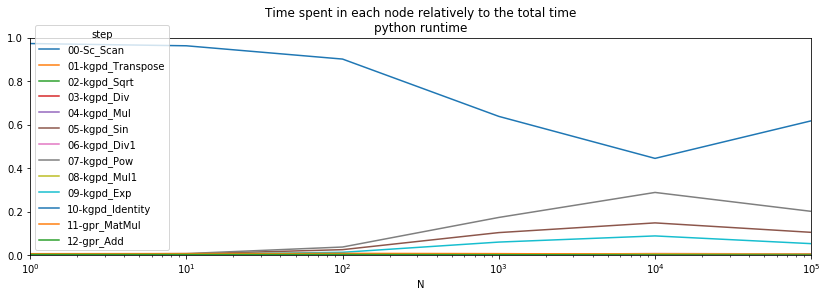

In [25]:
ax = (pivpy / total).T.plot(logx=True, figsize=(14, 4))
ax.set_ylim([0,1])
ax.set_title("Time spent in each node relatively to the total time\npython runtime");

The operator *Scan* is clearly time consuming when the batch size is small. *onnxruntime* is more efficient for this one.

In [26]:
res = list(enumerate_validated_operator_opsets(
            verbose=0, models={"GaussianProcessRegressor"}, opset_min=11,
            runtime='onnxruntime2', debug=False, node_time=True,
            filter_exp=lambda m, p: p == "b-reg"))

In [27]:
try:
    df = pandas.DataFrame(res[0]['bench-batch'])
except KeyError as e:
    raise RuntimeError("No model available in\n{}".format(df)) from e
df['step'] = df.apply(lambda row: '{0:02d}-{1}'.format(row['i'], row["name"]), axis=1)
pivort = df.pivot('step', 'N', 'time')
total = pivort.sum(axis=0)
pivort / total

N,1,10,100,1000,10000,100000
step,,,,,,
00-Sc_Scan,0.731274,0.705326,0.623449,0.421082,0.306604,0.341288
01-kgpd_Transpose,0.028946,0.035261,0.060258,0.114649,0.104415,0.108837
02-kgpd_Sqrt,0.020049,0.022375,0.022430,0.034846,0.048535,0.048785
03-kgpd_Div,0.023557,0.023208,0.019576,0.031976,0.047822,0.044994
04-kgpd_Mul,0.022322,0.023687,0.018845,0.032672,0.044840,0.047178
05-kgpd_Sin,0.021034,0.031956,0.097700,0.152870,0.144077,0.129719
06-kgpd_Div1,0.022784,0.022225,0.023467,0.032957,0.048833,0.048960
07-kgpd_Pow,0.023005,0.023030,0.020052,0.032470,0.045678,0.050562
08-kgpd_Mul1,0.021734,0.022138,0.019950,0.033509,0.047811,0.047297


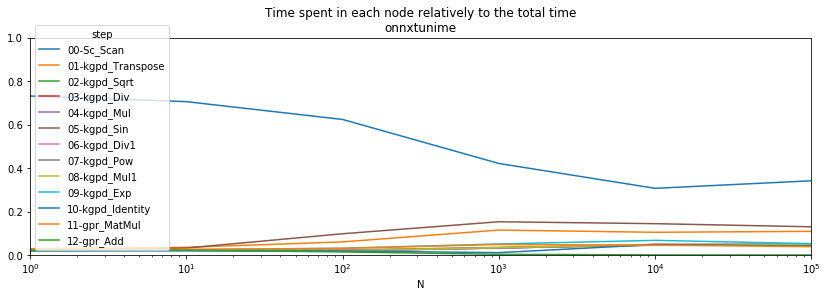

In [28]:
ax = (pivort / total).T.plot(logx=True, figsize=(14, 4))
ax.set_ylim([0,1])
ax.set_title("Time spent in each node relatively to the total time\nonnxtunime");

The results are relative. Let's see which runtime is best node by node.

In [29]:
(pivort - pivpy) / pivpy

N,1,10,100,1000,10000,100000
step,,,,,,
00-Sc_Scan,-0.851463,-0.835874,-0.828005,-0.414436,0.010242,-0.139700
01-kgpd_Transpose,1.102169,1.989205,5.465733,85.978680,448.994234,6032.186783
02-kgpd_Sqrt,0.705619,0.962325,1.066617,8.348630,11.748585,14.941695
03-kgpd_Div,1.051846,0.942962,0.727199,7.401945,10.045298,12.356436
04-kgpd_Mul,1.605703,1.566850,1.146842,11.053434,10.531230,13.461903
05-kgpd_Sin,1.025309,0.446850,-0.011707,0.315257,0.428514,0.936863
06-kgpd_Div1,1.830696,1.593759,1.482346,6.502184,11.660952,16.493323
07-kgpd_Pow,0.887378,-0.212097,-0.864134,-0.833350,-0.767573,-0.608105
08-kgpd_Mul1,1.729470,1.509914,0.930591,5.184221,12.457849,18.876912


Based on this, *onnxruntime* is faster for operators *Scan*, *Pow*, *Exp* and slower for all the others.

## Measuring the time with a custom dataset

We use the example [Comparison of kernel ridge and Gaussian process regression](https://scikit-learn.org/stable/auto_examples/gaussian_process/plot_compare_gpr_krr.html#sphx-glr-auto-examples-gaussian-process-plot-compare-gpr-krr-py).

In [30]:
import numpy
import pandas
import matplotlib.pyplot as plt
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import GridSearchCV
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, ExpSineSquared

rng = numpy.random.RandomState(0)

# Generate sample data
X = 15 * rng.rand(100, 1)
y = numpy.sin(X).ravel()
y += 3 * (0.5 - rng.rand(X.shape[0]))  # add noise

gp_kernel = ExpSineSquared(1.0, 5.0, periodicity_bounds=(1e-2, 1e1))
gpr = GaussianProcessRegressor(kernel=gp_kernel)
gpr.fit(X, y)

GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
                         kernel=ExpSineSquared(length_scale=1, periodicity=5),
                         n_restarts_optimizer=0, normalize_y=False,
                         optimizer='fmin_l_bfgs_b', random_state=None)

In [31]:
onx = to_onnx(gpr, X_test.astype(numpy.float64), dtype=numpy.float64)
%onnxview onx -r 1

In [32]:
oinfpy = OnnxInference(onx, runtime="python")
oinfort = OnnxInference(onx, runtime="onnxruntime2")

``runtime==onnxruntime2`` tells the class ``OnnxInference`` to use *onnxruntime* for every node independently, there are as many calls as there are nodes in the graph.

In [33]:
respy = oinfpy.run({'X': X_test}, node_time=True)
resort = oinfort.run({'X': X_test}, node_time=True)

In [34]:
df = pandas.DataFrame(respy[1]).merge(pandas.DataFrame(resort[1]), on=["i", "name", "op_type"],
                                    suffixes=("_py", "_ort"))
df['delta'] = df.time_ort - df.time_py
df

,i,name,op_type,time_py,time_ort,delta
0,0,Sc_Scan,Scan,0.009462,0.003689,-0.005773
1,1,kgpd_Transpose,Transpose,0.000025,0.000260,0.000235
2,2,kgpd_Sqrt,Sqrt,0.000026,0.000125,0.000099
3,3,kgpd_Div,Div,0.000033,0.000175,0.000141
4,4,kgpd_Mul,Mul,0.000020,0.000113,0.000093
5,5,kgpd_Sin,Sin,0.000093,0.000627,0.000534
6,6,kgpd_Div1,Div,0.000023,0.000234,0.000211
7,7,kgpd_Pow,Pow,0.000257,0.000148,-0.000108
8,8,kgpd_Mul1,Mul,0.000021,0.000123,0.000103
9,9,kgpd_Exp,Exp,0.000316,0.000171,-0.000144


The following function runs multiple the same inference and aggregates the results node by node.

In [35]:
from mlprodict.onnxrt.validate.validate import benchmark_fct
res = benchmark_fct(lambda X: oinfpy.run({'X': X_test}, node_time=True), 
                    X_test, node_time=True)

In [36]:
df = pandas.DataFrame(res)
df[df.N == 100]

,i,name,op_type,time,N,max_time,min_time,repeat,number
26,0,Sc_Scan,Scan,0.003865,100,0.004066,0.003756,5,8
27,1,kgpd_Transpose,Transpose,0.000011,100,0.000014,0.000009,5,8
28,2,kgpd_Sqrt,Sqrt,0.000014,100,0.000015,0.000013,5,8
29,3,kgpd_Div,Div,0.000014,100,0.000016,0.000012,5,8
30,4,kgpd_Mul,Mul,0.000011,100,0.000014,0.000008,5,8
31,5,kgpd_Sin,Sin,0.000057,100,0.000060,0.000056,5,8
32,6,kgpd_Div1,Div,0.000011,100,0.000012,0.000009,5,8
33,7,kgpd_Pow,Pow,0.000173,100,0.000195,0.000163,5,8
34,8,kgpd_Mul1,Mul,0.000011,100,0.000011,0.000010,5,8
35,9,kgpd_Exp,Exp,0.000204,100,0.000224,0.000190,5,8


In [37]:
df100 = df[df.N == 100]

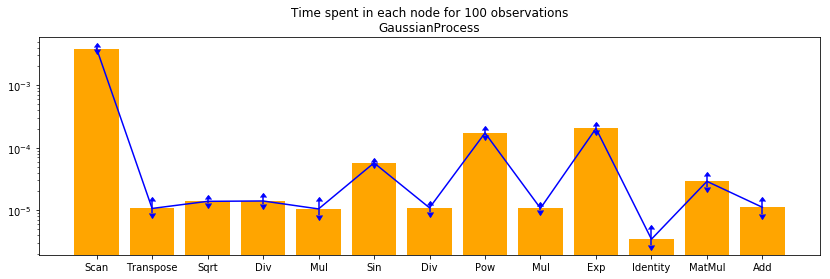

In [38]:
fig, ax = plt.subplots(1, 1, figsize=(14, 4))
ax.bar(df100.i, df100.time, align='center', color='orange')
ax.set_xticks(df100.i)
ax.set_yscale('log')
ax.set_xticklabels(df.op_type)
ax.errorbar(df100.i, df100.time, 
            numpy.abs(df100[["min_time", "max_time"]].T.values - df100.time.values.ravel()),
            uplims=True, lolims=True, color='blue')
ax.set_title("Time spent in each node for 100 observations\nGaussianProcess");

In [39]:
df100c = df100.cumsum()

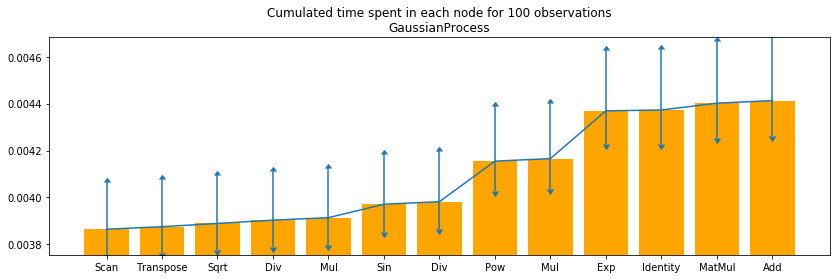

In [40]:
fig, ax = plt.subplots(1, 1, figsize=(14, 4))
ax.bar(df100.i, df100c.time, align='center', color='orange')
ax.set_xticks(df100.i)
#ax.set_yscale('log')
ax.set_ylim([df100c.min_time.min(), df100c.max_time.max()])
ax.set_xticklabels(df.op_type)
ax.errorbar(df100.i, df100c.time, 
            numpy.abs((df100c[["min_time", "max_time"]].T.values - df100c.time.values.ravel())),
            uplims=True, lolims=True)
ax.set_title("Cumulated time spent in each node for 100 observations\nGaussianProcess");

## onnxruntime2 / onnxruntime1

The runtime ``onnxruntime1`` uses *onnxruntime* for the whole ONNX graph. There is no way to get the computation time for each node except if we create a ONNX graph for each intermediate node.

In [41]:
oinfort1 = OnnxInference(onx, runtime='onnxruntime1')

In [42]:
split = oinfort1.build_intermediate()
split

OrderedDict([('scan0_2981255177944', OnnxInference(...)),
             ('scan1_2981255177944', OnnxInference(...)),
             ('kgpd_transposed0', OnnxInference(...)),
             ('kgpd_Y0', OnnxInference(...)),
             ('kgpd_C03', OnnxInference(...)),
             ('kgpd_C02', OnnxInference(...)),
             ('kgpd_output02', OnnxInference(...)),
             ('kgpd_C01', OnnxInference(...)),
             ('kgpd_Z0', OnnxInference(...)),
             ('kgpd_C0', OnnxInference(...)),
             ('kgpd_output01', OnnxInference(...)),
             ('kgpd_output0', OnnxInference(...)),
             ('gpr_Y0', OnnxInference(...)),
             ('GPmean', OnnxInference(...))])

In [43]:
dfs = []
for k, v in split.items():
    print("node", k)
    res = benchmark_fct(lambda x: v.run({'X': x}), X_test)
    df = pandas.DataFrame(res)
    df['name'] = k
    dfs.append(df.reset_index(drop=False))

node scan0_2981255177944
node scan1_2981255177944
node kgpd_transposed0
node kgpd_Y0
node kgpd_C03
node kgpd_C02
node kgpd_output02
node kgpd_C01
node kgpd_Z0
node kgpd_C0
node kgpd_output01
node kgpd_output0
node gpr_Y0
node GPmean


In [44]:
df = pandas.concat(dfs)
df.head()

,index,1,10,100,1000,10000,100000,name
0,average,0.000880,0.000696,0.000993,0.003342,0.032901,0.601387,scan0_2981255177944
1,deviation,0.000335,0.000057,0.000156,0.000083,0.003735,0.000000,scan0_2981255177944
2,min_exec,0.000619,0.000625,0.000859,0.003266,0.027778,0.601387,scan0_2981255177944
3,max_exec,0.001900,0.000859,0.001209,0.003462,0.036578,0.601387,scan0_2981255177944
4,repeat,20.000000,20.000000,5.000000,5.000000,3.000000,1.000000,scan0_2981255177944


In [45]:
df100c = df[df['index'] == "average"]
df100c_min = df[df['index'] == "min_exec"]
df100c_max = df[df['index'] == "max_exec"]
ave = df100c.iloc[:, 4]
ave_min = df100c_min.iloc[:, 4]
ave_max = df100c_max.iloc[:, 4]
ave.shape, ave_min.shape, ave_max.shape
index = numpy.arange(ave.shape[0])

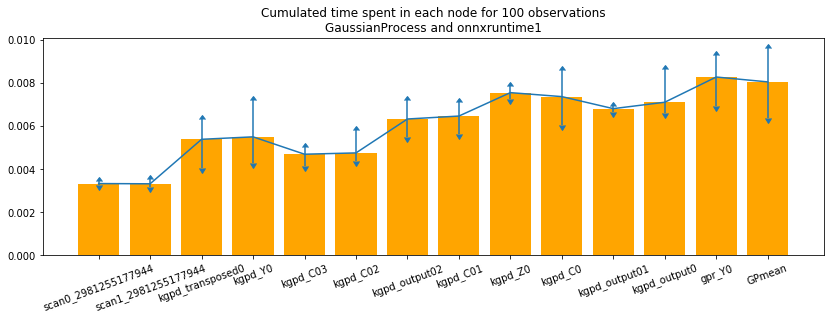

In [46]:
fig, ax = plt.subplots(1, 1, figsize=(14, 4))
ax.bar(index, ave, align='center', color='orange')
ax.set_xticks(index)
ax.set_xticklabels(df100c.name)
for tick in ax.get_xticklabels():
    tick.set_rotation(20)
ax.errorbar(index, ave, 
            numpy.abs((numpy.vstack([ave_min.values, ave_max.values]) - ave.values.ravel())),
            uplims=True, lolims=True)
ax.set_title("Cumulated time spent in each node for 100 observations\nGaussianProcess and onnxruntime1");

The visual graph helps matching the output names with the operator type. The curve is not monotononic because each experiment computes every output from the start. The number of repetitions should be increased. Documentation of function [benchmark_fct](http://www.xavierdupre.fr/app/mlprodict/helpsphinx/mlprodict/onnxrt/validate/validate.html?highlight=benchmark_fct#mlprodict.onnxrt.validate.validate.benchmark_fct) tells how to do it.